In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

quiet = True # to disable unwanted output
#quiet = False
def log(*args):
    if not quiet:
        print(args)


/home/tg/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
print('Feature Names', boston.feature_names)
dfX = boston.data
dfY = np.array([boston.target]).transpose()
assert dfX.shape[0] == dfY.shape[0]

n = dfX.shape[0]
test_split_rule = np.array(range(n)) % 7 == 0
train_split_rule = np.invert(test_split_rule)

trainX, trainY = dfX[train_split_rule], dfY[train_split_rule]
testX, testY = dfX[test_split_rule], dfY[test_split_rule]


print('All', dfX.shape, dfY.shape)
print('Test', testX.shape, testY.shape)
print('Train', trainX.shape, trainY.shape)


Feature Names ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
All (506, 13) (506, 1)
Test (73, 13) (73, 1)
Train (433, 13) (433, 1)


# 1. Histograms and pearson correlation



Correlations between the attributes
          0         1         2         3         4         5         6   \
0   1.002315  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  -0.197276  1.002315  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.396280 -0.537783  1.002315  0.000000  0.000000  0.000000  0.000000   
3  -0.054158 -0.038522  0.050507  1.002315  0.000000  0.000000  0.000000   
4   0.410524 -0.525903  0.769347  0.065319  1.002315  0.000000  0.000000   
5  -0.206593  0.314229 -0.387829  0.066559 -0.308899  1.002315  0.000000   
6   0.351814 -0.586247  0.654674  0.081180  0.734113 -0.239191  1.002315   
7  -0.370380  0.672366 -0.713743 -0.097458 -0.771612  0.209400 -0.750088   
8   0.607248 -0.317635  0.597033 -0.021546  0.611365 -0.211677  0.470596   
9   0.567033 -0.318496  0.722513 -0.051311  0.668685 -0.288305  0.520563   
10  0.279365 -0.383817  0.376030 -0.145421  0.183605 -0.356928  0.264867   
11 -0.358765  0.180031 -0.360012  0.054895 -0.386504

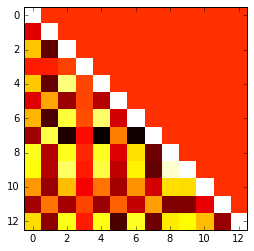

('CRIM', 0.38859443435207547)
('ZN', 0.36382754420139768)
('INDUS', 0.48418563338201681)
('CHAS', 0.20407144132697344)
('NOX', 0.4258130776462164)
('RM', 0.69252269454509585)
('AGE', 0.39108230278590012)
('DIS', 0.25300487309124547)
('RAD', 0.38638415658601943)
('TAX', 0.46993468487617812)
('PTRATIO', 0.5064403651254078)
('B', 0.34422912357951185)
('LSTAT', 0.74168271373323336)


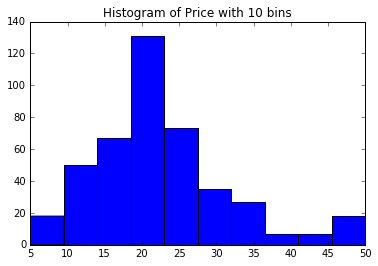

Histogram


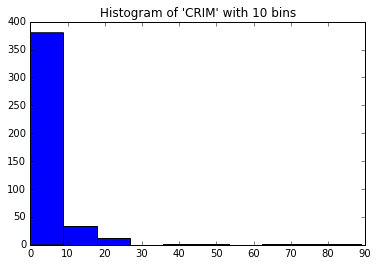

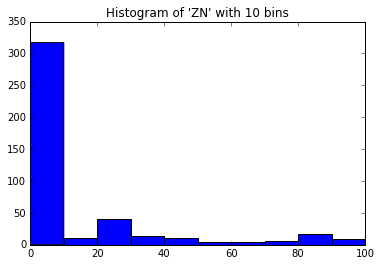

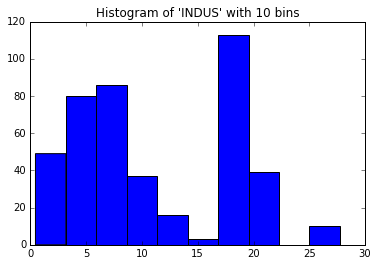

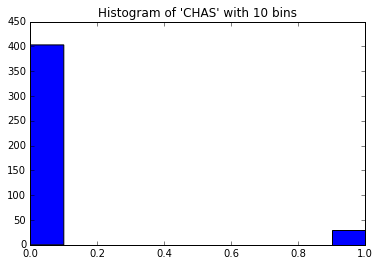

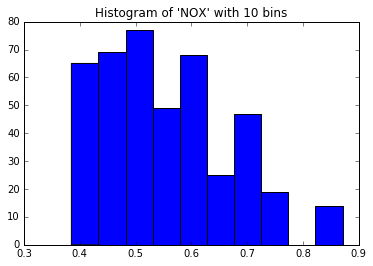

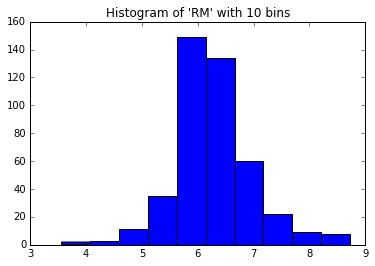

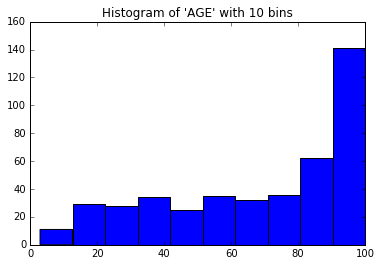

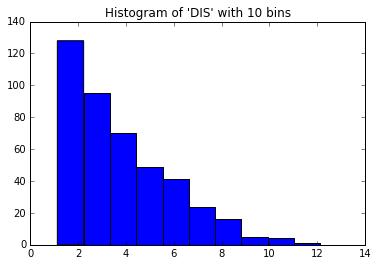

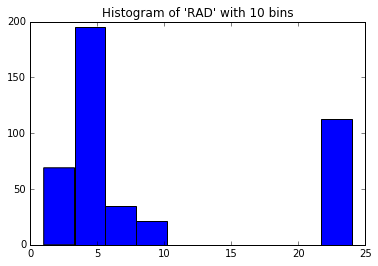

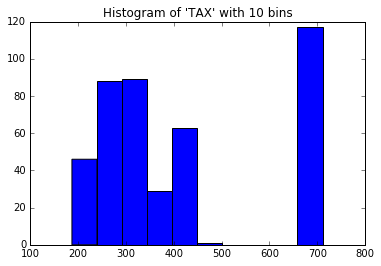

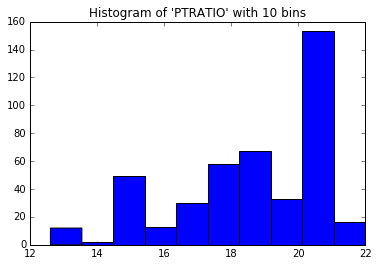

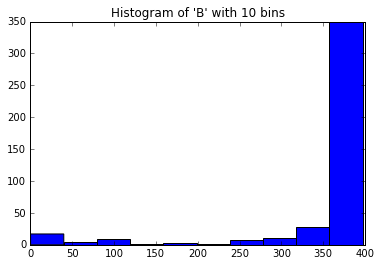

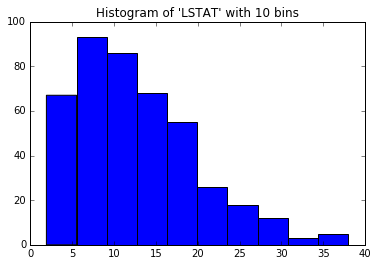

In [18]:
n_attrs = trainX.shape[1]
attrs = [trainX[:, i] for i in range(n_attrs)]
stds = [a.std() for a in attrs]

corrs = np.zeros(shape=(n_attrs, n_attrs))
for i, a in enumerate(attrs):
    for j in range(0, i + 1):
        b = attrs[j]
        res = np.cov(a, b) / (stds[i] * stds[j])
        corrs[i][j] = res[0,1]

print("Correlations between the attributes")
print(pd.DataFrame(corrs))
plt.imshow(corrs, cmap='hot', interpolation='nearest')
plt.show()


def pearson_cor(X, Y, names):
    Y = Y[:, 0]
    assert X.shape[0] == Y.shape[0]
    assert X.shape[1] == len(names)
    y_std = Y.std()
    cor = []
    for i in range(X.shape[1]): # each column    
        attr = trainX[:, i]
        # Correlation between the attribs and target value
        cor_ab = np.cov(attr, Y) / (stds[i] * y_std)
        cor_ab = abs(cor_ab[0,1])
        cor.append((names[i], cor_ab))
    return cor
    
for i, cor_ab in enumerate(pearson_cor(trainX, trainY, boston.feature_names)):
    print(cor_ab)


bins = 10
plt.hist(trainY, bins=bins)
plt.title("Histogram of Price with %d bins" % bins)
plt.show()

print("Histogram")
for i, attr in enumerate(attrs):
    plt.hist(attr, bins=bins)
    plt.title("Histogram of '%s' with %d bins" % (boston.feature_names[i], bins))
    plt.show()


# 2 Linear Regression

In [15]:
def predict(X, W):
    return np.matmul(X, W)

def MSECost(Y2, Y1):
    # Cost      = 1/N  SIGMA[(XW-Y)^2]
    return float(np.sum((Y2 - Y1) ** 2) / len(Y2))


def analytical_optimizer(X, Y):
    return np.matmul(
        np.matmul(
            np.linalg.pinv(np.matmul(X.transpose(), X)),
            X.transpose()),
        Y)

def gradient_desc(X, Y, W, alpha,
                  num_iter = 1000, conv_tol=0.01, print_interval = 500):
    c = float('inf')
    log("Learn Rate", alpha)
    for i in range(num_iter):
        # 
        # delta =  2/N SIGMA[(XW - Y)*x]
        predY = predict(X, W)
        diff = predY - Y
        delta = np.sum(np.multiply(X, diff), axis=0) # sum top to bottom for each attribute
        delta  = delta * 2.0 / len(Y)
        delta = np.array([delta]).transpose()        # restore vector shape of (n_attr x 1)
        
        W = (W - alpha * delta)
        if i % print_interval == 0:
            predY = predict(X, W)
            newcost = MSECost(predY, Y)
            log("#%d, cost = %.8g" % (i, newcost))
            if np.isnan(newcost) or np.isinf(newcost) or np.isneginf(newcost):
                raise Exception("ERROR: number overflow, please adjust learning rate")
            diff = abs(newcost - c)
            c = newcost
            if diff < conv_tol:
                log("Converged with tolerance %f " % conv_tol)
                break            
        if i % (print_interval * 10) == 0:
            log(W.flatten())
    return W


# compute means and stds
class LinearRegression(object):
    
    def __init__(self, X, Y, learn_rate=0.001, num_iter=10000, conv_tol=0.01, opt='analytical'):
        
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)        
        X = self.normalize(X)
        self.n_attrs = X.shape[1]
        if opt == 'gradient_desc':
            W = np.random.rand(self.n_attrs, 1)
            self.W = gradient_desc(X, Y, W, alpha=learn_rate,
                                    num_iter=num_iter, conv_tol=conv_tol)
        elif opt == 'analytical':
            self.W = analytical_optimizer(X, Y)
        else:
            raise Exception('Unknown Optimizer %s' % opt)
    
    def normalize(self, X):
        X = (X - self.means) / self.stds
        # Bias is added as a weight to simplify the calculations
        X = np.insert(X, 0, 1, axis=1)
        return X
    
    def predict(self, X, normalize=True):
        if normalize:
            X = self.normalize(X)
        return np.matmul(X, self.W)
            
    
alpha = 0.001
conv_tol = 0.0001
num_iter = 50000
for opt_val in ["analytical", "gradient_desc"]:
    print("Using %s optimizer" % opt_val)
    linreg = LinearRegression(trainX, trainY, alpha, num_iter, conv_tol, opt=opt_val)
    print("W=", linreg.W.flatten())

    train_mse_cost = MSECost(linreg.predict(trainX), trainY)
    test_mse_cost = MSECost(linreg.predict(testX), testY)
    print('Train MSE::', train_mse_cost, '\tTest MSE::', test_mse_cost)

Using analytical optimizer
W= [ 22.46351039  -0.9673241    1.04542152  -0.17351707   0.92139354
  -1.6205974    2.72573311  -0.26723668  -3.11240878   2.48363548
  -1.91078756  -1.88799963   0.82940209  -3.67532974]
Train MSE:: 20.950144508 	Test MSE:: 28.4179164975
Using gradient_desc optimizer
W= [ 22.46351039  -0.96304402   1.03690774  -0.20102114   0.92552579
  -1.61552751   2.730206    -0.27205352  -3.11536104   2.41554577
  -1.83310388  -1.88512184   0.82866899  -3.67292127]
Train MSE:: 20.950868436 	Test MSE:: 28.4554242596


# Ridge Regression

In [5]:

def MSECost_ridge(X, W, Y, lambd):
    # Cost      = 1/N  \SIGMA[(XW-Y)^2] + lambd W||_2^2
    predY = predict(X, W)
    cost = float(np.sum((predY - Y) ** 2)) / len(Y)
    cost += lambd * np.sum((W) ** 2)
    return cost

def gradient_desc_ridge(X, Y, W, alpha, lambd,
                  num_iter = 1000, conv_tol=0.01, check_interval = 500):
    c = float('inf')
    log("Learn Rate", alpha)
    for i in range(num_iter):
        # 
        # delta =  2/N SIGMA[(XW - Y)*x] + 2 * \lambd * W
        diff = predict(X, W) - Y
        delta = np.sum(np.multiply(X, diff), axis=0) # sum top to bottom for each attribute
        delta = delta * 2.0 / len(Y)
        delta = np.array([delta]).transpose()        # restore vector shape of (n_attr x 1)
        delta  = delta + (2 * lambd * W)           # Vectors addition

        W = (W - alpha * delta)
        
        if i % check_interval == 0:
            predY = predict(X, W)
            #print(np.concatenate((Y, predY), axis=1))
            newcost = MSECost_ridge(X, W, Y, lambd)
            
            log("#%d, cost = %.8g" % (i, newcost))
            if np.isnan(newcost) or np.isinf(newcost) or np.isneginf(newcost):
                raise Exception("ERROR: number overflow, please adjust learning rate")
            diff = abs(newcost - c)
            c = newcost
            if diff < conv_tol:
                log("Converged with tolerance %f " % conv_tol)
                break            
        if not quiet and i % (check_interval * 10) == 0:
            print(W.flatten())
    return W


# compute means and stds
class RidgeRegression(object):
    
    def __init__(self, X, Y, learn_rate=0.001, lambd=0.1, num_iter=1000, conv_tol=0.1):
        
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)        
        X = self.normalize(X)
        self.n_attrs = X.shape[1]
        W = np.random.rand(self.n_attrs, 1)
        self.lambd = lambd
        self.W = gradient_desc_ridge(X, Y, W, alpha=learn_rate, lambd=lambd,
                                num_iter=num_iter, conv_tol=conv_tol)
    
    def normalize(self, X):
        X = (X - self.means) / self.stds
        # Bias is added as a weight to simplify the calculations
        X = np.insert(X, 0, 1, axis=1)
        return X
    
    def predict(self, X, normalize=True):
        if normalize:
            X = self.normalize(X)
        return np.matmul(X, self.W)
    
    def find_cost(self, X, Y, lambd=None, normalize=True):
        if lambd is None:
            lambd = self.lambd
        if normalize:
            X = self.normalize(X)
        predY = self.predict(X, normalize=False)
        return MSECost_ridge(X, self.W, Y, lambd)
    
alpha = 0.001
conv_tol = 0.0001
num_iter = 100000
lambds = [0.01, 0.1, 1.0]
results = []
quiet = True
print("\n\nLambda\t\tTrain MSE\t\tTest MSE")
for lambd in lambds:
    ridreg = RidgeRegression(trainX, trainY, alpha, lambd, num_iter, conv_tol)
    train_mse = ridreg.find_cost(trainX, trainY, lambd=lambd)
    test_mse = ridreg.find_cost(testX, testY, lambd=lambd)
    t = (lambd, train_mse, test_mse)
    print("\t\t".join(map(lambda x: str(x), t)))




Lambda		Train MSE		Test MSE
0.01		26.429152097		34.0586529506
0.1		70.6765515879		78.3585597002
1.0		292.935651071		302.554099681


----
# 10 fold cross validation

In [8]:
alpha = 0.01
conv_tol = 0.001
num_iter = 100000
k = 10

def k_fold_cv(X, Y, lambd, k):
    n = len(Y)
    # Shuffle 
    shuf_idx = np.random.permutation(n)
    X, Y = X[shuf_idx], Y[shuf_idx]
    assert k > 1 and k <= n 
    ss = n / k # split size
    # split
    accuracy = []
    for i in range(k):        
        start, end = i * ss, (i + 1) * ss
        if i == k-1 and end < n:
            # anything left over shall go to the last split (if n is not multiple of k)
            end = n
        
        # ith split is for testing
        test_X, test_Y =  X[start:end], Y[start:end]
        # everything else for training
        train_X = np.delete(X, np.s_[start, end], axis=0)
        train_Y = np.delete(Y, np.s_[start, end], axis=0)
        ridreg = RidgeRegression(train_X, train_Y, alpha, lambd, num_iter, conv_tol)
        acc = ridreg.find_cost(test_X, test_Y)
        accuracy.append(acc)
    return np.array(accuracy).mean()

lambds = [0.0001, 0.001, 0.01, 0.1, 1, 10]

print("\n\nLambda\t\tTrain MSE\t\tTest MSE")
for lambd in lambds:
    train_mse = k_fold_cv(trainX, trainY, lambd, k)
    ridreg = RidgeRegression(trainX, trainY, alpha, lambd, num_iter, conv_tol) 
    test_mse = ridreg.find_cost(testX, testY, lambd=lambd)
    t = (lambd, train_mse, test_mse)
    print("\t\t".join(map(lambda x: str(x), t)))
    



Lambda		Train MSE		Test MSE
0.0001		20.9657503744		28.4990072828
0.001		21.6565607474		29.0132253011
0.01		26.3888333257		34.0391584508
0.1		70.6610115862		78.3467656591
1		292.764839814		302.55457715
10		527.303867571		552.172840312


----

# Feature Selection


## 1. Select top 4 features, fit linear regressor.
  

In [19]:
alpha = 0.001


top4TrainX = np.zeros(shape=(len(trainY), 0))
top4TestX = np.zeros(shape=(len(testY), 0))
tuples = pearson_cor(trainX, trainY, boston.feature_names)
target_cor = dict(tuples)
top4= sorted(target_cor, key=target_cor.get, reverse=True)[:4]
for k in top4:
    column = np.where(boston.feature_names == k)[0][0]
    
    x = np.array([trainX[:, column]]).transpose()
    top4TrainX = np.concatenate((top4TrainX, x), axis=1)
    
    x = np.array([testX[:, column]]).transpose()
    top4TestX = np.concatenate((top4TestX, x), axis=1)

print("Top4 attrs::", top4, '\n from', target_cor)
linreg = LinearRegression(top4TrainX, trainY, alpha)
train_mse_cost = MSECost(linreg.predict(top4TrainX), trainY)
test_mse_cost = MSECost(linreg.predict(top4TestX), testY)

print('Train MSE::', train_mse_cost, " Test MSE::", test_mse_cost)

Top4 attrs:: ['LSTAT', 'RM', 'PTRATIO', 'INDUS'] 
 from {'CRIM': 0.38859443435207547, 'ZN': 0.36382754420139768, 'B': 0.34422912357951185, 'LSTAT': 0.74168271373323336, 'AGE': 0.39108230278590012, 'TAX': 0.46993468487617812, 'RAD': 0.38638415658601943, 'CHAS': 0.20407144132697344, 'NOX': 0.4258130776462164, 'RM': 0.69252269454509585, 'INDUS': 0.48418563338201681, 'PTRATIO': 0.5064403651254078, 'DIS': 0.25300487309124547}
Train MSE:: 26.4066042155  Test MSE:: 31.4962025449


## 2. Select top 4 features iteratively from residual errors

In [20]:
alpha = 0.001
Y_train = trainY
Y_test = testY
X_train = trainX
names = boston.feature_names

X_test = testX

Z_train = np.zeros(shape=(X_train.shape[0], 0)) 
Z_test = np.zeros(shape=(X_test.shape[0], 0)) 

pred_Y = None
for i in range(4):
    
    # first time we use the target, then on we use the Y - predY
    
    _Y = Y_train if pred_Y is None else np.subtract(Y_train, pred_Y) 
    corrs = dict(pearson_cor(X_train, _Y, names))
    top1 = sorted(corrs, key=corrs.get)[-1]
    print("Choose : ", top1)
    top1_col = names.tolist().index(top1)
    
    x = np.array([X_train[:, top1_col]]).transpose()
    Z_train = np.concatenate((Z_train, x), axis=1)
    
    x = np.array([X_test[:, top1_col]]).transpose()
    Z_test = np.concatenate((Z_test, x), axis=1)
    
    linreg = LinearRegression(Z_train, Y_train, alpha)
    pred_Y = linreg.predict(Z_train)
    train_mse_cost = MSECost(pred_Y, Y_train)
    test_mse_cost = MSECost(linreg.predict(Z_test), Y_test)

    print('Train MSE::', train_mse_cost, " Test MSE::", test_mse_cost)
    
    # for the next iteration
    X_train = np.delete(X_train, top1_col, axis=1)
    X_test = np.delete(X_test, top1_col, axis=1)
    names = np.delete(names, top1_col)


Choose :  LSTAT
Train MSE:: 37.5682291124  Test MSE:: 43.9181708494
Choose :  RM
Train MSE:: 29.5454831972  Test MSE:: 36.2967947962
Choose :  B
Train MSE:: 28.6939844449  Test MSE:: 34.3784509663
Choose :  CHAS
Train MSE:: 26.9461754396  Test MSE:: 38.5301578153


## Selection with highest Mutual information


# Selection with brute force

In [21]:
import itertools

least_cost = float('inf')
best_combination = None
for cols in itertools.combinations(range(trainX.shape[1]), 4):
    Z_train = np.zeros(shape=(X_train.shape[0], 0)) 
    Z_test = np.zeros(shape=(X_test.shape[0], 0)) 
    
    for col in cols:
        x = np.array([trainX[:, col]]).transpose()
        Z_train = np.concatenate((Z_train, x), axis=1)
    
        x = np.array([testX[:, col]]).transpose()
        Z_test = np.concatenate((Z_test, x), axis=1)
    
    linreg = LinearRegression(Z_train, Y_train, alpha)
    train_mse_cost = MSECost(linreg.predict(Z_train), Y_train)
    test_mse_cost = MSECost(linreg.predict(Z_test), Y_test)
    if test_mse_cost < least_cost:
        best_combination = cols 
        least_cost = test_mse_cost
    print(cols, 'Train MSE::', train_mse_cost, " Test MSE::", test_mse_cost)

print(best_combination, least_cost)

(0, 1, 2, 3) Train MSE:: 54.7305210127  Test MSE:: 68.4461303194
(0, 1, 2, 4) Train MSE:: 58.4730836378  Test MSE:: 66.5960116117
(0, 1, 2, 5) Train MSE:: 35.9095646094  Test MSE:: 40.1036741833
(0, 1, 2, 6) Train MSE:: 58.4526510355  Test MSE:: 67.0295679399
(0, 1, 2, 7) Train MSE:: 52.9819649629  Test MSE:: 61.2636219244
(0, 1, 2, 8) Train MSE:: 58.4845270675  Test MSE:: 66.8775129902
(0, 1, 2, 9) Train MSE:: 57.5894674556  Test MSE:: 65.8612209485
(0, 1, 2, 10) Train MSE:: 51.0885005837  Test MSE:: 58.5613690869
(0, 1, 2, 11) Train MSE:: 57.0148737203  Test MSE:: 66.9792322345
(0, 1, 2, 12) Train MSE:: 36.9717042231  Test MSE:: 43.2933913214
(0, 1, 3, 4) Train MSE:: 57.3466185047  Test MSE:: 70.1550812401
(0, 1, 3, 5) Train MSE:: 34.9548344956  Test MSE:: 46.7586303987
(0, 1, 3, 6) Train MSE:: 58.3617103424  Test MSE:: 75.4728580207
(0, 1, 3, 7) Train MSE:: 59.7400311193  Test MSE:: 74.693859929
(0, 1, 3, 8) Train MSE:: 59.0208550445  Test MSE:: 74.3981989669
(0, 1, 3, 9) Train MSE:

# 3.4 Feature expansion

In [22]:
Z_train = trainX
Z_test = testX

for i in range(n_attrs):
    xi_train = np.array([trainX[:, i]]).transpose()
    xi_test = np.array([testX[:, i]]).transpose()
    
    for j in range(0, i+1):
        xj_train = np.array([trainX[:, j]]).transpose()
        xj_test = np.array([testX[:, j]]).transpose()

        Z_train = np.concatenate((Z_train, xi_train * xj_train), axis=1)
        Z_test = np.concatenate((Z_test, xi_test * xj_test), axis=1)

print('Train Shape:', Z_train.shape)
print('Test Shape:', Z_test.shape)
linreg = LinearRegression(Z_train, trainY, alpha)
pred_Y = linreg.predict(Z_train)
train_mse_cost = MSECost(pred_Y, trainY)
test_mse_cost = MSECost(linreg.predict(Z_test), testY)

print('Train MSE::', train_mse_cost, " Test MSE::", test_mse_cost)



Train Shape: (433, 104)
Test Shape: (73, 104)
Train MSE:: 6.68639815515  Test MSE:: 21.0152571898


In [17]:
np.arange(1, 10) *  np.arange(11, 20)

array([ 11,  24,  39,  56,  75,  96, 119, 144, 171])